Forecast the  Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [64]:
data = pd.read_excel('Airlines+Data.xlsx')

In [65]:
from datetime import datetime

In [66]:
data['Month'] = pd.to_datetime(data['Month'],infer_datetime_format= True)
indexed_data = data.set_index(['Month'])

In [67]:
indexed_data.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


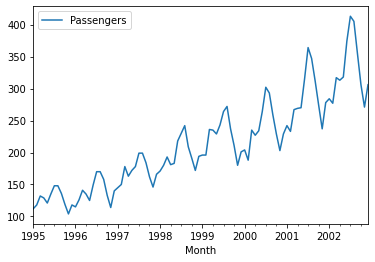

In [68]:
indexed_data.plot()
plt.show()

it is a increasing trend

In [69]:
indexed_data

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [70]:
train = indexed_data.head(66)
test = indexed_data.tail(30)

In [71]:
train

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2000-02-01,188
2000-03-01,235
2000-04-01,227


In [72]:
test

,Passengers
Month,
2000-07-01,302
2000-08-01,293
2000-09-01,259
2000-10-01,229
2000-11-01,203
2000-12-01,229
2001-01-01,242
2001-02-01,233
2001-03-01,267


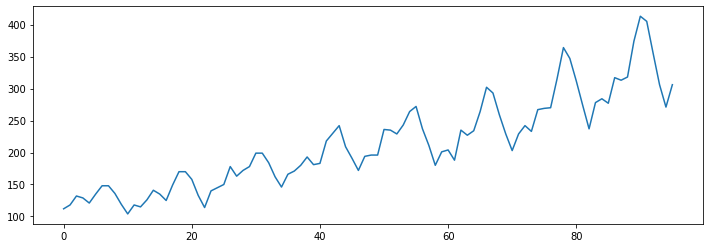

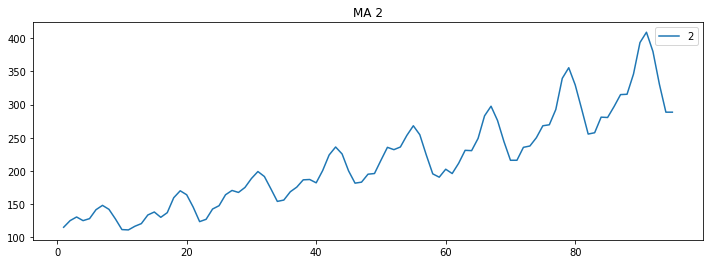

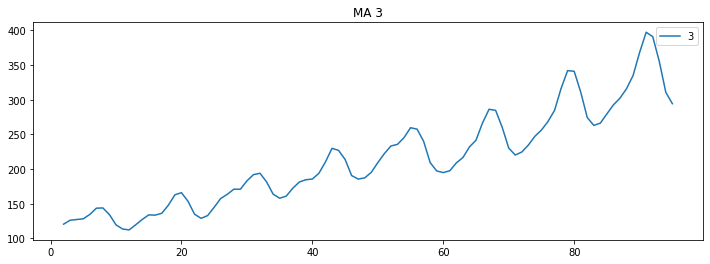

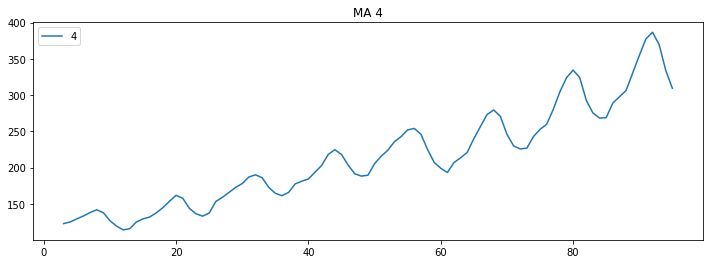

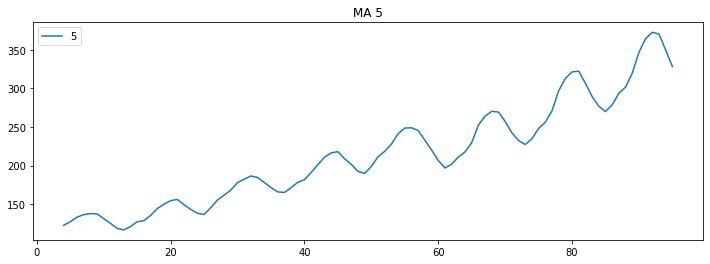

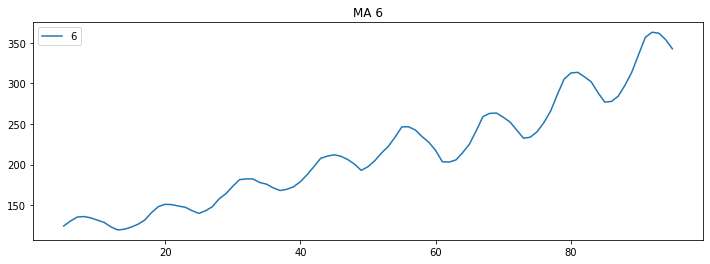

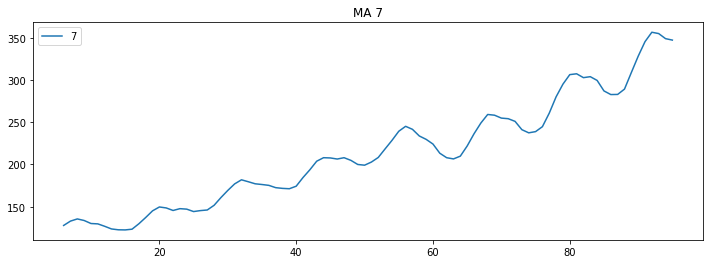

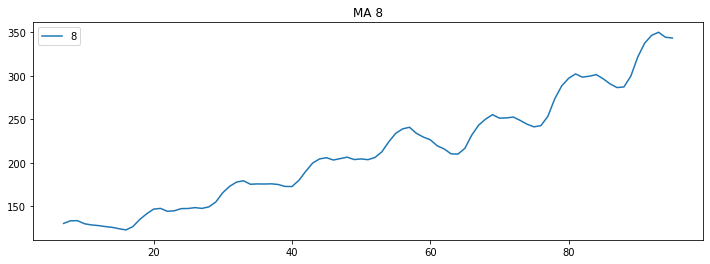

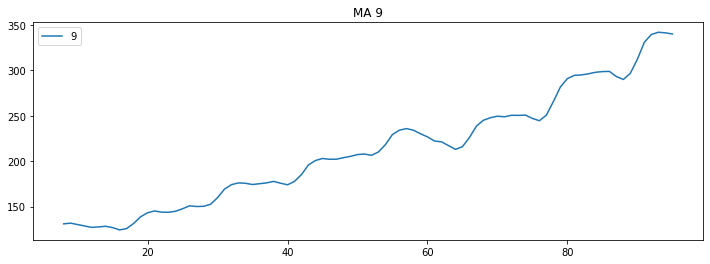

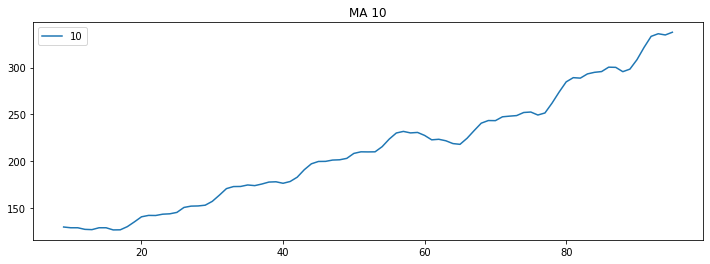

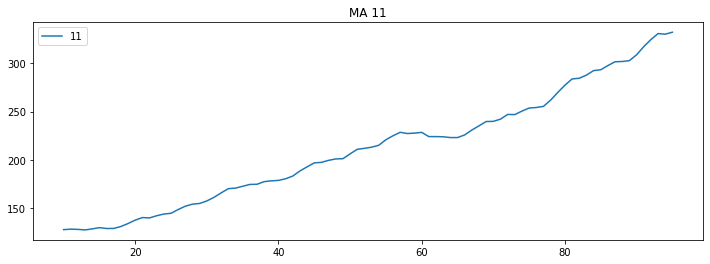

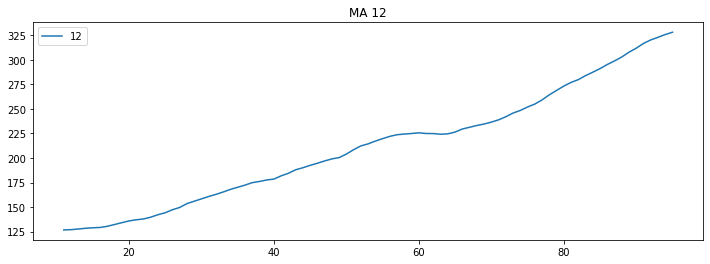

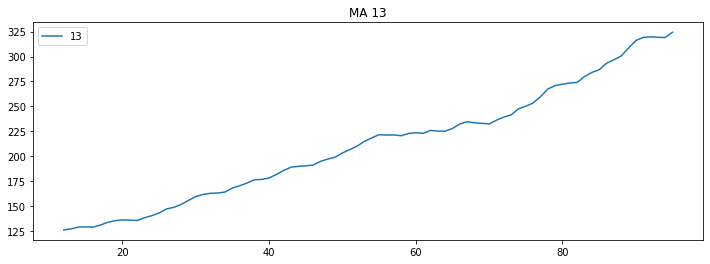

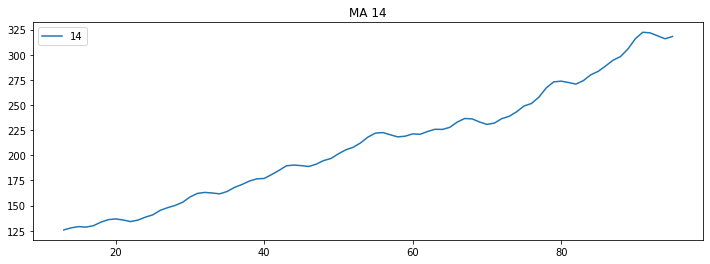

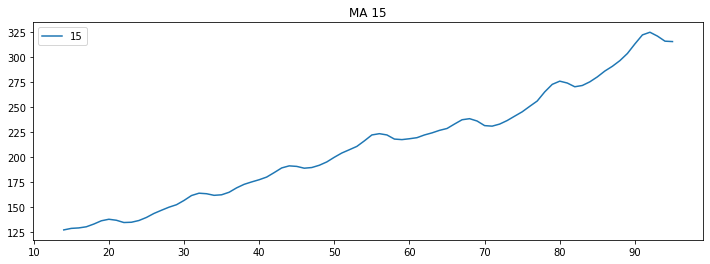

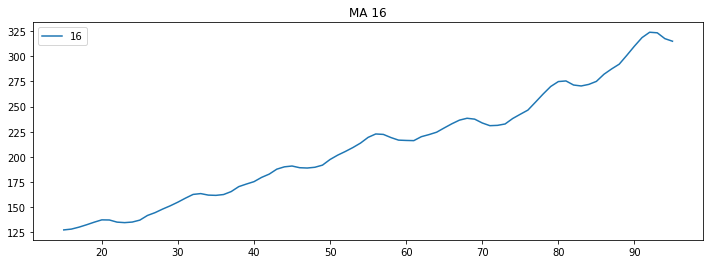

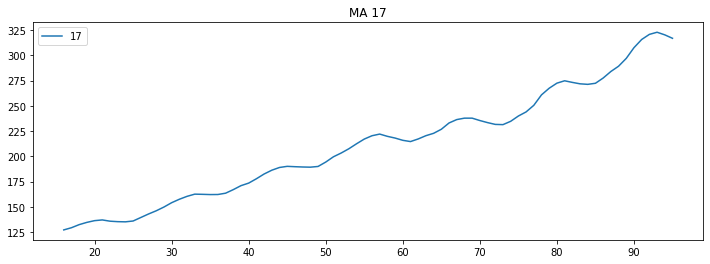

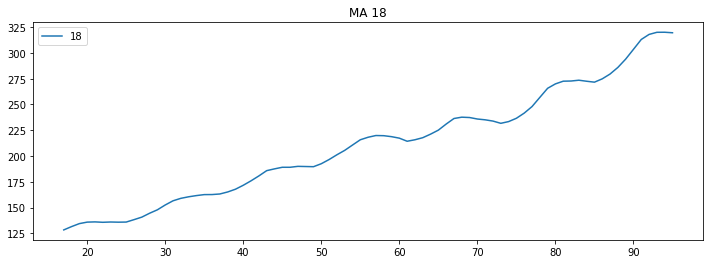

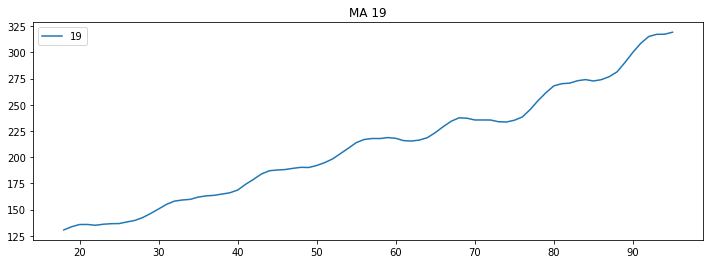

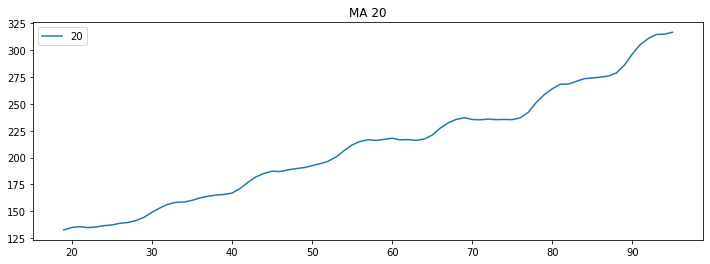

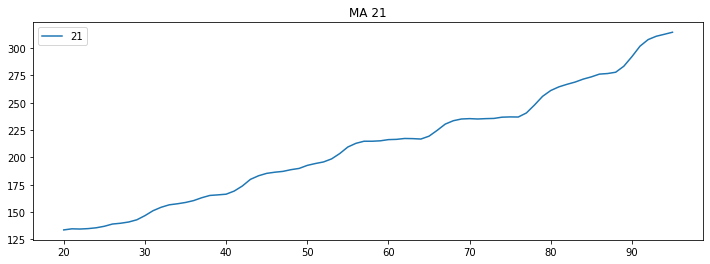

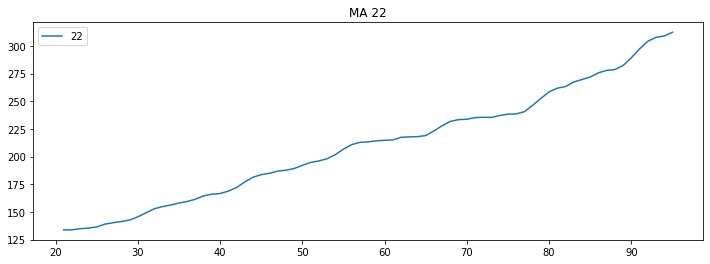

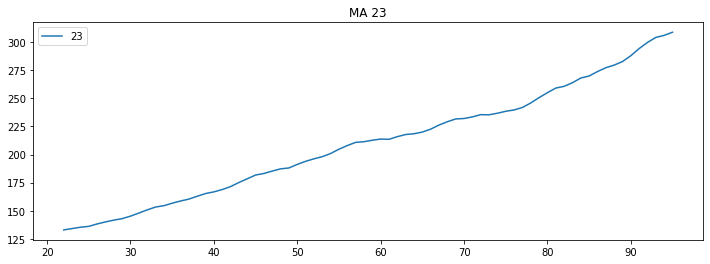

In [73]:
plt.figure(figsize=(12,4))
data.Passengers.plot(label="org")
for i in range(2,24):
    plt.figure(figsize=(12,4))


    data["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("MA "+str(i))
    plt.legend(loc='best')
    plt.show()

We can see after MA(moving average)12 the spikes stated increasing so the  period of seasonality is 12

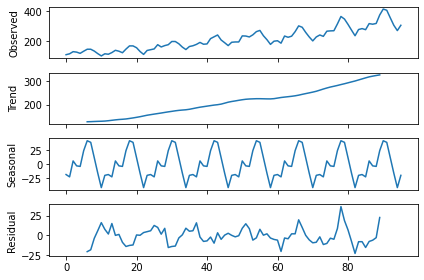

In [74]:
decompose_ts_add = seasonal_decompose(data.Passengers,freq=12)
decompose_ts_add.plot()
plt.show()

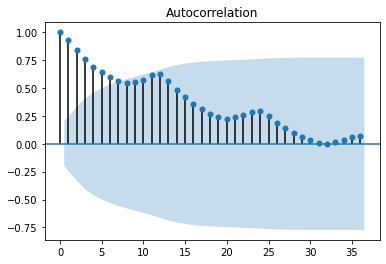

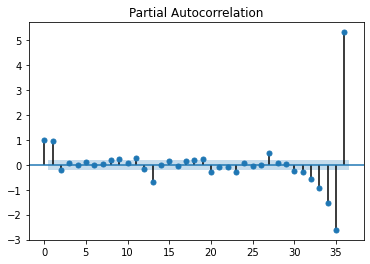

In [75]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Passengers,lags=36)
tsa_plots.plot_pacf(data.Passengers,lags=36)
plt.show()

In [76]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [77]:
def RMSE(pred,org):
    rmse = sqrt(mean_squared_error(org, pred))
    return rmse

# **Single Exponential**

In [78]:
ses_model = SimpleExpSmoothing(train['Passengers']).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
RMSE(pred_ses,test.Passengers) 

83.60714677338491

# **Holt method**

In [79]:
# Holt method 
hw_model = Holt(train['Passengers']).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
RMSE(pred_hw,test.Passengers) 

101.66319881083105

# **Holts winter exponential smoothing with additive seasonality and additive trend**

In [80]:
hwe_model_add_add = ExponentialSmoothing(train['Passengers'],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
RMSE(pred_hwe_add_add,test.Passengers) 

30.576533086057918

# **Holts winter exponential smoothing with multiplicative seasonality and additive trend**

In [81]:
hwe_model_mul_add = ExponentialSmoothing(train['Passengers'],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
RMSE(pred_hwe_mul_add,test.Passengers)

36.38934284131755

In [82]:
split_point = len(data) - 10
dataset, validation = indexed_data[0:split_point], indexed_data[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 86, Validation 10


In [83]:
dataset

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2001-10-01,274
2001-11-01,237
2001-12-01,278


In [84]:

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [85]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [86]:
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=78.563
ARIMA(0, 0, 1) RMSE=44.789
ARIMA(0, 1, 0) RMSE=25.903
ARIMA(0, 1, 1) RMSE=25.356
ARIMA(0, 1, 2) RMSE=27.772
ARIMA(0, 1, 3) RMSE=23.806
ARIMA(0, 1, 4) RMSE=22.640
ARIMA(0, 2, 0) RMSE=32.474
ARIMA(0, 2, 1) RMSE=26.640
ARIMA(0, 2, 2) RMSE=25.942
ARIMA(1, 0, 0) RMSE=26.036
ARIMA(1, 0, 1) RMSE=25.282
ARIMA(1, 0, 2) RMSE=414.823
ARIMA(1, 1, 0) RMSE=25.679
ARIMA(1, 2, 0) RMSE=31.603
ARIMA(2, 0, 0) RMSE=25.620
ARIMA(2, 0, 1) RMSE=26.215
ARIMA(2, 1, 0) RMSE=25.467
ARIMA(2, 2, 0) RMSE=30.414
ARIMA(3, 0, 0) RMSE=25.510
ARIMA(3, 0, 1) RMSE=25.031
ARIMA(3, 1, 0) RMSE=25.648
ARIMA(3, 2, 0) RMSE=30.597
ARIMA(4, 0, 0) RMSE=25.764
ARIMA(4, 1, 0) RMSE=25.344
ARIMA(4, 2, 0) RMSE=29.205
ARIMA(4, 2, 1) RMSE=26.016
Best ARIMA(0, 1, 4) RMSE=22.640


In [87]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [88]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

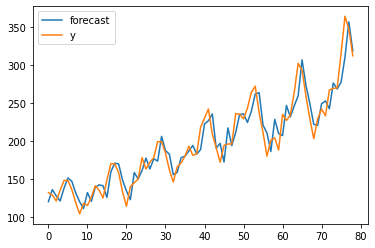

In [89]:
# fit model
model = ARIMA(X, order=(0,1,4))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 79)
plt.show()

In [90]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

59.81126803956852

In [91]:
forecast

array([285.79388225, 282.98502262, 292.0884655 , 297.75471162,
       299.87039957, 301.98608752, 304.10177547, 306.21746342,
       308.33315137, 310.44883933])

# **We can use ARIMA(0,1,4) for forecasting**